In [1]:
import numpy as np 
from numpy import asarray
import tensorflow as tf 
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
import os
import shutil 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from PIL import Image
import keras
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.layers
import cv2
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
gpu_options= tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction = 0.5)
tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options= gpu_options))

In [ ]:
data_directory = 'Card_Glass/'

In [ ]:
data_list = os.listdir(data_directory)
train_list = []
label_list = []
text_list = []

for d in data_list:
    train_list.append(d + "/img.png")
    label_list.append(d + "/label.png")
    text_list.append(d + "/label_names.txt")

In [ ]:
print(text_list[53])

In [ ]:
print(len(train_list))
print(len(label_list))
print(len(text_list))

In [ ]:
height , width = (512,512)
m = len(label_list)
X = np.zeros([m, height, width, 3])
Y = np.zeros([m, height, width, 3])

for i in tqdm(range(m)):
    img = mpimg.imread(data_directory  + train_list[i])
    image = Image.open(data_directory  + train_list[i])
    if image.mode == 'RGBA':
        image = image.convert("RGB")
        img = np.array(image)
    X[i] = img
    Y[i] = mpimg.imread(data_directory + label_list[i])
    

In [ ]:
for n in tqdm(range(m)):
    for i in range(height):
        for j in range(width):
            for c in range(3):
                if(Y[n,i,j,c] > 0):
                    Y[n,i,j,c] = 1

In [ ]:
colour_label = np.array([[0.0 ,0.0 ,0.0], [1.0,0.0,0.0]])

In [ ]:
def change_colour(t, k):
  if(k == "'_background_\n'"):
    t = [0.0, 0.0, 0.0]
    #print('background')
  elif(k == "cardboard\n"):
    t = [0.0, 0.0, 1.0]
    #print("C")
  elif(k == "glass\n"):
    t = [0.0, 1.0, 0.0]
    #print("D")
  elif(k == "metal\n"):
    t = [0.0, 1.0, 1.0]
    #print("EL")
  elif(k == "paper\n"):
    t = [1.0, 0.0, 0.0]
    #print("ER")
  elif(k == "plastic\n"):
    t = [1.0, 0, 1.0]
    #print("L")
  elif(k == "trash\n"):
    t = [1.0, 1.0, 0.0]
    #print("S")
  else:
    t = [0.0,0.0,0.0]
  return t


In [ ]:
def lab_checker(t, n):
  #print('we r in')
  f = open(data_directory + text_list[n], 'r')
  fil = f.readlines()
  counter = 0
  
  for line in fil:
    if(tuple(t) == tuple(colour_label[counter])):
      t = change_colour(t, line)
      return np.array(t)
    counter = counter + 1
  f.close()
  return np.array(t)


In [ ]:
for n in tqdm(range(m)):
    for i in range(height):
        for j in range(width):
            t = Y[n, i, j, :]
            Y[n, i, j, :] = lab_checker(t, n)

In [2]:
X = np.load('X-file.npy')
Y = np.load('Y_file.npy')

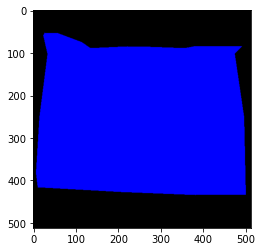

In [3]:
plt.imshow(Y[53])

In [14]:
import cv2
x_array = list()
y_array = list()
for i in range(len(X)):
    x = cv2.resize(X[i], (128,128))
    y = cv2.resize(Y[i], (128,128))
    x_array.append(x)
    y_array.append(y)


X128 = np.array(x_array)
Y128 = np.array(y_array)

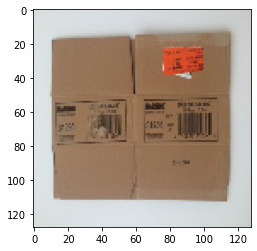

In [15]:
plt.imshow(X128[6])

In [16]:
np.save('x128.npy', X128)
np.savez('x128_comp.npz', X128)

# Training

In [11]:
x1 = np.load("X_file.npz")['arr_0']
x2 = np.load("X-CAR-GLAS.npy")
x3 = np.load("x128-paper-metal.npy")

X = np.concatenate((x1, x2, x3))

In [12]:
X.shape

(716, 128, 128, 3)

In [15]:
y1 = np.load("Y_file.npz")['arr_0']
y2 = np.load("Y-CAR-GLAS.npy")
y3 = np.load("y128-paper-metal.npy")

Y = np.concatenate((y1, y2, y3))

In [16]:
Y.shape

(716, 128, 128, 3)

In [17]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [18]:
# Function for a single resolution convolution operations

def conv_layer(input_layer, conv_channels, kernel_size = (3,3), pool_stride = (2,2), dropout_rate = 0.2, padding = 'same', activation = 'relu'):        
    print(input_layer.shape)
    layer_1 = tf.keras.layers.Conv2D(conv_channels, kernel_size, activation = activation, padding = padding, kernel_initializer = 'he_normal')(input_layer)
    print(layer_1.shape)
    layer_2 = tf.keras.layers.BatchNormalization()(layer_1)
    layer_3 = tf.keras.layers.Dropout(dropout_rate)(layer_2)
    layer_4 = tf.keras.layers.Conv2D(conv_channels, kernel_size, activation = activation, padding = padding, kernel_initializer = 'he_normal')(layer_3)
    layer_5 = tf.keras.layers.BatchNormalization()(layer_4)
    layer_6 = tf.keras.layers.MaxPool2D(pool_stride)(layer_5)
    
    return layer_1,layer_6

In [19]:
# Function for a single resolution convolution operation at the terminal position

def terminal_conv_layer(input_layer, conv_channels, kernel_size = (3,3), dropout_rate = 0.2, padding = 'same', activation = 'relu'):
    
    layer_1 = tf.keras.layers.Conv2D(conv_channels, kernel_size, activation = activation, padding = padding, kernel_initializer = 'he_normal')(input_layer)
    layer_2 = tf.keras.layers.BatchNormalization()(layer_1)
    layer_3 = tf.keras.layers.Dropout(dropout_rate)(layer_2)
    layer_4 = tf.keras.layers.Conv2D(conv_channels, kernel_size, activation = activation, padding = padding, kernel_initializer = 'he_normal')(layer_3)
    layer_5 = tf.keras.layers.BatchNormalization()(layer_4)
    
    return layer_5

In [20]:
# Function for a single resolution transpose convolution operation

def transpose_conv_layer(input_layer, skip_layer, conv_channels, kernel_size = (3,3), transpose_kernel_size = (2,2), dropout_rate = 0.2, padding = 'same', activation = 'relu', transpose_strides = (2,2)):
    print(input_layer.shape)
    layer_1 = tf.keras.layers.Conv2DTranspose(conv_channels, transpose_kernel_size, strides = transpose_strides, padding = padding )(input_layer)
    print(layer_1.shape, skip_layer.shape)
    layer_2 = tf.keras.layers.concatenate([layer_1, skip_layer], axis = 3)
    
    layer_3 = tf.keras.layers.Conv2D(conv_channels, kernel_size, activation = activation, padding = padding, kernel_initializer = 'he_normal')(layer_2)
    layer_4 = tf.keras.layers.BatchNormalization()(layer_3)
    layer_5 = tf.keras.layers.Dropout(dropout_rate)(layer_4)
    layer_6 = tf.keras.layers.Conv2D(conv_channels, kernel_size, activation = activation, padding = padding, kernel_initializer = 'he_normal')(layer_5)
    layer_7 = tf.keras.layers.BatchNormalization()(layer_6)  
     
    
    return layer_7

In [53]:
def modified_unet_model(height, width, image_channels):
    
    inputs = tf.keras.layers.Input((height, width, image_channels))
    normalized_inputs = tf.keras.layers.Lambda(lambda x: x/255)(inputs)

    S1,D1 = conv_layer(normalized_inputs, 32)
    S2,D2 = conv_layer(D1, 64)
    S3,D3 = conv_layer(D2, 128)
    S4,D4 = conv_layer(D3, 256)
    #S5,D5 = conv_layer(D4, 512)

    T1 = terminal_conv_layer(D4, 512)

    #U1 = transpose_conv_layer(T1, S5, 512)
    U2 = transpose_conv_layer(T1, S4, 256)
    U3 = transpose_conv_layer(U2, S3, 128)
    U4 = transpose_conv_layer(U3, S2, 64)
    U5 = transpose_conv_layer(U4, S1, 32)

    outputs = tf.keras.layers.Conv2D(3,(1,1), activation = tf.nn.relu)(U5)

    model = Model(inputs = [inputs], outputs = [outputs])
    
    model.summary()
    
    return model

In [56]:
def train_the_model(X,Y,optimizer,loss,metrics,epochs,verbose):
    
    h = X.shape[1]
    
    w = X.shape[2]
    c = X.shape[3]
    print(h, w, c)
    
    unet_model = modified_unet_model(h,w,c)
    
    unet_model.compile(optimizer = optimizer, loss = loss, metrics = [metrics])
    history = unet_model.fit(X,Y,validation_data= (x_test, y_test),epochs = epochs, verbose = verbose, batch_size = 32)
    
    return history, unet_model

In [57]:
model_history , trained_model = train_the_model(x_train,y_train,'adam','mean_squared_error','acc',100,1)

128 128 3
(None, 128, 128, 3)
(None, 128, 128, 32)
(None, 64, 64, 32)
(None, 64, 64, 64)
(None, 32, 32, 64)
(None, 32, 32, 128)
(None, 16, 16, 128)
(None, 16, 16, 256)
(None, 8, 8, 512)
(None, 16, 16, 256) (None, 16, 16, 256)
(None, 16, 16, 256)
(None, 32, 32, 128) (None, 32, 32, 128)
(None, 32, 32, 128)
(None, 64, 64, 64) (None, 64, 64, 64)
(None, 64, 64, 64)
(None, 128, 128, 32) (None, 128, 128, 32)
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 128, 128, 3)  0           input_6[0][0]                    
___________________________________________________________________________________

In [58]:
trained_model.save('weights.h5')

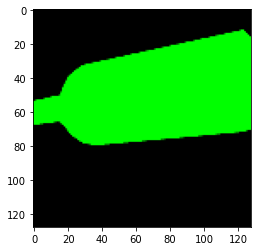

In [59]:
plt.imshow(Y[360])

In [60]:
print(len(x_test))

144


In [61]:
n = 15

i = x_test[n]
'''
image = Image.open(data_directory  + train_list[n])
if image.mode == 'RGBA':
    image = image.convert("RGB")
    i = np.array(image)

'''
i = i.reshape((1,128,128,3))


print(i.shape)
img1 = trained_model.predict(i)

(1, 128, 128, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


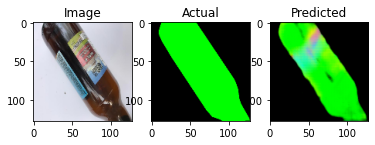

In [62]:
figure, axis = plt.subplots(1,3)
axis[0].imshow(i[0])
axis[0].set_title("Image")

axis[1].imshow(y_test[n])
axis[1].set_title("Actual")

axis[2].imshow(img1[0])
axis[2].set_title("Predicted")


plt.show()


In [63]:
Y_Pred = trained_model.predict(X)

In [64]:
for n in tqdm(range(len(X))):
    for i in range(128):
        for j in range(128):
            for c in range(3):
                if(Y_Pred[n,i,j,c] > 0):
                    Y_Pred[n,i,j,c] = 1

100%|██████████| 716/716 [01:57<00:00,  6.09it/s]


In [65]:
intersection = np.sum(np.logical_and(Y, Y_Pred))
union = np.sum(np.logical_or(Y_Pred, Y))
iou = np.mean((intersection)/union)
dice = 2*np.mean(intersection/(np.sum(Y_Pred)+np.sum(Y)))

In [66]:
print(iou)

0.8133269651063874


In [67]:
print(dice)

0.9007872947006338


In [ ]:
'for d in range(len(data_list)):
    plt.imsave(data_directory + data_list[d] + "/label_new.png", Z[d])
    plt.imsave(data_directory + data_list[d] + "/pred.png", Y_Pred[d])


In [68]:
trained_model.save("model")

INFO:tensorflow:Assets written to: model\assets


In [69]:
classinter = [0, 0, 0, 0, 0, 0]
classunion = [0, 0, 0, 0, 0, 0]

In [70]:
def classin(r, cl):
    if(r == tuple([0.0, 0.0, 1.0])):
        cl[0] = cl[0] + 1
    elif(r == tuple([0.0, 1.0, 0.0])):
        cl[1] = cl[1] + 1
    elif(r == tuple([0.0, 1.0, 1.0])):
        cl[2] = cl[2] + 1
    elif(r == tuple([1.0, 0.0, 0.0])):
        cl[3] = cl[3] + 1
    elif(r == tuple([1.0, 0.0, 1.0])):
        cl[4] = cl[4] + 1
    elif(r == tuple([1.0, 1.0, 0.0])):
        cl[5] = cl[5] + 1
    return cl


In [71]:
def classun(r, cl):
    if(r == tuple([0.0, 0.0, 1.0])):
        cl[0] = cl[0] + 1
    elif(r == tuple([0.0, 1.0, 0.0])):
        cl[1] = cl[1] + 1
    elif(r == tuple([0.0, 1.0, 1.0])):
        cl[2] = cl[2] + 1
    elif(r == tuple([1.0, 0.0, 0.0])):
        cl[3] = cl[3] + 1
    elif(r == tuple([1.0, 0.0, 1.0])):
        cl[4] = cl[4] + 1
    elif(r == tuple([1.0, 1.0, 0.0])):
        cl[5] = cl[5] + 1
    return cl

In [75]:
for n in tqdm(range(len(X))):
    for i in range(128):
        for j in range(128):
            yp = tuple(Y_Pred[n, i, j, :])
            yt = tuple(Y[n, i, j, :])
            if(yp == yt):
                classinter = classin(yp, classinter)
                classunion = classun(yt, classunion)
            else:
                classunion = classun(yt, classunion)
                classunion = classun(yp, classunion)


100%|██████████| 716/716 [08:25<00:00,  1.42it/s]


In [77]:
print("IOU Score Class Wise")
print("#######################")
print("Cardboard:    {}", (classinter[0]/classunion[0])*100)
print("Glass:     {}", (classinter[1]/classunion[1])*100)
print("Metal:  {}", (classinter[2]/classunion[2])*100)
print("Paper: {}", (classinter[3]/classunion[3])*100)
print("Plastic:       {}", (classinter[4]/classunion[4])*100)
print("Trash:   {}", (classinter[5]/classunion[5])*100)

IOU Score Class Wise
#######################
Cardboard:    {} 71.49466742601494
Glass:     {} 72.58070233604617
Metal:  {} 76.95968186041037
Paper: {} 74.71953002882226
Plastic:       {} 66.21394608453419
Trash:   {} 69.43633299286428
